In [ ]:
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import BinaryAccuracy
from keras.layers import Dense
from google.colab.patches import cv2_imshow

import numpy as np
import os
import cv2
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Define Model

In [ ]:
# instantiate VGG16 model, with top linear layers omitted
vgg_model = VGG16(include_top=False, weights='imagenet')
vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

#Load Images

In [ ]:
X = np.zeros((1,25088))
y = []

# load brad images
brad_dir = '/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Brad Faces/'
os.chdir('/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Brad Faces')
for path in os.listdir(brad_dir):
    img = cv2.imread(path)
    img.resize((224, 224, 3))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    features = vgg_model.predict(x, verbose=False)  # run each image through VGG16
    features = features.flatten()
    X = np.vstack((X, features))
    y.append(1)

# load non-brad images    
non_brad_dir = '/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Non-Brad Faces/'
os.chdir('/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Non-Brad Faces')
for path in os.listdir(non_brad_dir):
    img = cv2.imread(path)
    img.resize((224, 224, 3))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    features = vgg_model.predict(x, verbose=False) # run each image through VGG16
    features = features.flatten()
    X = np.vstack((X, features))
    y.append(0)
X = X[1:] # chop off first row of zeros
y = np.array(y) # turn list into an array
print(X.shape)
print(len(y))

(1835, 25088)
1835


In [ ]:
non_brad_dir = '/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Non-Brad Faces/'
brad_dir = '/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Brad Faces/'

# Train Linear Layers

In [ ]:
os.chdir('/content/drive/MyDrive/CIS 5810 Final Project/Model Weights')

In [ ]:
# if(model_fc):
#     del model_fc

# create 4 layer linear model
model_fc = Sequential()
model_fc.add(Dense(1000, activation="selu"))
model_fc.add(Dense(500, activation="selu"))
model_fc.add(Dense(50, activation="selu"))
model_fc.add(Dense(1, activation="sigmoid"))
model_fc.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
# train and test linear model
model_fc.fit(X_train, y_train)

y_out = model_fc.predict(X_test)
y_pred = list((y_out > 0.5).flatten().astype(int))
acc = (y_test == y_pred).sum() / len(y_test)
print('Test Accuracy:', acc)

12/12 [==============================] - 0s 2ms/step
Test Accuracy: 0.8637602179836512


In [ ]:
# save weights to file in drive to use when classifying faces real time
model_fc.save_weights('/content/drive/MyDrive/CIS 5810 Final Project/Model Weights/brad_weights')

# Predicting One Image

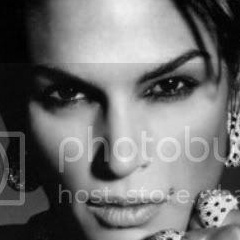

(1, 25088)
1/1 [==============================] - 0s 15ms/step
[[0.08074421]]


In [ ]:
# What is the probability that Cindy Crawford is Brad Pitt?
os.chdir('/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Non-Brad Faces')
path = os.listdir(non_brad_dir)[0]
img = cv2.imread(path)
cv2_imshow(img)
img = cv2.resize(img, (224,224))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
features = vgg_model.predict(x, verbose=False)
features = features.reshape(1,-1)
print(features.shape)
out = model_fc.predict(features)
print(out)
# 8%! Pretty low!

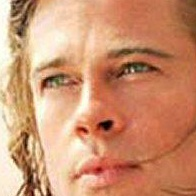

(1, 25088)
1/1 [==============================] - 0s 16ms/step
[[0.947715]]


In [ ]:
# What is the probability that Brad Pitt is Brad Pitt?
os.chdir('/content/drive/MyDrive/CIS 5810 Final Project/Brad_dataset/images/Brad Faces')
path = os.listdir(brad_dir)[0]
img = cv2.imread(path)
cv2_imshow(img)
img = cv2.resize(img, (224,224))
# img.resize((224, 224, 3))
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
features = vgg_model.predict(x, verbose=False)
features = features.reshape(1,-1)
print(features.shape)
out = model_fc.predict(features)
print(out)
# 95%! Very Nice!